# LAB 5: Text classification with Naive Bayes

Objectives:

* Train and evaluate Naive Bayes text classifiers
* Cross-validation
* Hyperparameter search

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

### Load and preprocess data

In [2]:
df = pd.read_parquet(
    "s3://ling583/rcv1-politics.parquet", storage_options={"anon": True}
)

In [3]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [4]:
def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [5]:
df["tokens"] = df["text"].progress_apply(tokenize)

  0%|          | 0/60509 [00:00<?, ?it/s]

---

### Baseline dummy classifier

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

Set up five-fold cross-validation. We'll use the same training/test splits for all our experiments so the results will be easier to compare.

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

In [8]:
baseline = DummyClassifier()
cross_val_score(baseline, df["tokens"], df["pol"], cv=cv) # accuracy 

array([0.92951578, 0.92951578, 0.92951578, 0.92943315, 0.92950996])

In [9]:
predicted = cross_val_predict(baseline, df["tokens"], df["pol"], cv=cv)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96     56243
        True       0.00      0.00      0.00      4266

    accuracy                           0.93     60509
   macro avg       0.46      0.50      0.48     60509
weighted avg       0.86      0.93      0.90     60509



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----

### Bernoulli Naive Bayes

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline

Set up a pipeline: first convert tokenized text into feature vectors, then apply naive Bayes classifier

In [11]:
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

In [12]:
predicted = cross_val_predict(bnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.98      0.90      0.93     56243
        True       0.35      0.73      0.47      4266

    accuracy                           0.88     60509
   macro avg       0.66      0.81      0.70     60509
weighted avg       0.93      0.88      0.90     60509



---

### Hyperparameter search

In [13]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36235")
client

Client Scheduler: tcp://127.0.0.1:36235 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [14]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [15]:
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

In [16]:
bnb = make_pipeline(CountVectorizer(analyzer=identity), BernoulliNB())

In [17]:
%%time

search = RandomizedSearchCV(
    bnb, {"bernoullinb__alpha": loguniform(1e-10, 10.0)}, n_iter=25, scoring="f1"
)
search.fit(df["tokens"], df["pol"])

CPU times: user 21.1 s, sys: 2.85 s, total: 23.9 s
Wall time: 2min 1s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f15b94fd1e0>)),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=25,
                   param_distributions={'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f15114f15b0>},
                   scoring='f1')

In [18]:
search.best_params_

{'bernoullinb__alpha': 2.143690835447402e-09}

In [19]:
search.best_score_

0.598709746214858

In [20]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

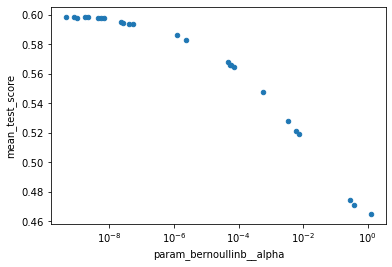

In [21]:
cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

In [22]:
%%time

search = RandomizedSearchCV(
    bnb,
    {
        "countvectorizer__min_df": randint(1, 5),
        "bernoullinb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 20.7 s, sys: 2.67 s, total: 23.4 s
Wall time: 2min 11s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f15b94fd1e0>)),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=25,
                   param_distributions={'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f150f94c580>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f150fa06a60>},
                   scoring='f1')

In [23]:
search.best_params_, search.best_score_

({'bernoullinb__alpha': 9.817081101957688e-10, 'countvectorizer__min_df': 1},
 0.5980382244767232)

In [24]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

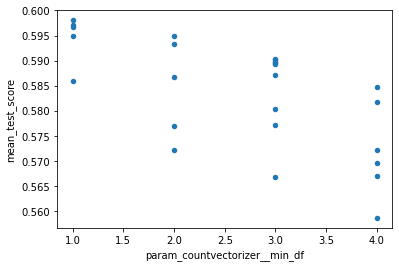

In [25]:
cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

<AxesSubplot:xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

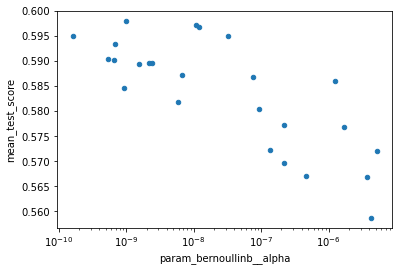

In [26]:
cv_results.plot(
    "param_bernoullinb__alpha", "mean_test_score", kind="scatter", logx=True
)

<AxesSubplot:xlabel='param_bernoullinb__alpha', ylabel='mean_test_score'>

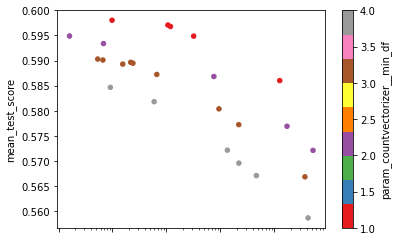

In [27]:
cv_results.plot(
    "param_bernoullinb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

In [28]:
%%time

search = RandomizedSearchCV(
    bnb,
    {
        "countvectorizer__min_df": [1],
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "bernoullinb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 21.1 s, sys: 2.72 s, total: 23.8 s
Wall time: 3min 52s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f15b94fd1e0>)),
                                             ('bernoullinb', BernoulliNB())]),
                   n_iter=25,
                   param_distributions={'bernoullinb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f150eaa5bb0>,
                                        'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f150eaa55e0>,
                                        'countvectorizer__min_df': [1]},
                   scoring='f1')

In [29]:
search.best_params_, search.best_score_

({'bernoullinb__alpha': 6.118692984003126e-09,
  'countvectorizer__max_df': 0.5149633938385083,
  'countvectorizer__min_df': 1},
 0.6002815089243192)

<AxesSubplot:xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

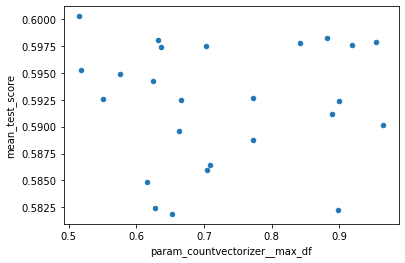

In [30]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

---

### Evaluate final model

In [31]:
bnb.set_params(
    bernoullinb__alpha=1e-10, countvectorizer__min_df=1, countvectorizer__max_df=0.73
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x7f15b94fd1e0>,
                                 max_df=0.73)),
                ('bernoullinb', BernoulliNB(alpha=1e-10))])

In [32]:
predicted = cross_val_predict(bnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.98      0.96      0.97     56243
        True       0.54      0.68      0.60      4266

    accuracy                           0.94     60509
   macro avg       0.76      0.82      0.78     60509
weighted avg       0.94      0.94      0.94     60509

